# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config

In [ ]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [ ]:
# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Нормализуем значения пикселей
x_train = x_train / 255
x_test = x_test / 255

# Преобразуем целочисленные пиксели к типа float32
# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train = tf.reshape(tf.cast(x_train, tf.float32), [-1, num_features])
x_test = tf.reshape(tf.cast(x_test, tf.float32), [-1, num_features])

# Делаем данные категориальными
y_train = to_categorical(y_train, 10)

# Перемешаем тренировочные данные
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=5000).batch(batch_size)

In [ ]:
# Создадим нейронную сеть
class DenseNN(tf.Module):
    def __init__(self, outputs, activate="relu"):
        super().__init__()
        self.outputs = outputs
        self.activate = activate
        self.fl_init = False

    def __call__(self, x):
        if not self.fl_init:
            self.w = tf.random.truncated_normal((x.shape[-1], self.outputs), stddev=0.1, name="w")
            self.b = tf.zeros([self.outputs], dtype=tf.float32, name="b")

            self.w = tf.Variable(self.w)
            self.b = tf.Variable(self.b, trainable=False)

            self.fl_init = True

        y = x @ self.w + self.b

        if self.activate == "relu":
            return tf.nn.relu(y)
        elif self.activate == "softmax":
            return tf.nn.softmax(y)

        return y


class SequentialModule(tf.Module):
    def __init__(self):
        super().__init__()
       # Первый слой, состоящий из 128 нейронов
       # Место для вашего кода
        self.layer_1 = DenseNN(128)
       # Второй слой, состоящий из 256 нейронов
       # Место для вашего кода
        self.layer_2 = DenseNN(256)
       # Выходной слой
       # Место для вашего кода
        self.layer_3 = DenseNN(10, activate="softmax")

    def __call__(self, x):
      y = self.layer_1(x)
      y = self.layer_2(y)
      y = self.layer_3(y)
      return y

In [ ]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
cross_entropy = lambda y_true, y_pred: tf.reduce_mean(tf.losses.categorical_crossentropy(y_true, y_pred))

In [ ]:
# Создадим экзампляр нейронной сети
model = SequentialModule()
# Функция обучения нейросети
opt = tf.optimizers.SGD(learning_rate=0.001)
@tf.function
def train_batch(x_batch, y_batch):
  with tf.GradientTape() as tape:
    f_loss = cross_entropy(y_batch, model(x_batch))

  grads = tape.gradient(f_loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))

  return f_loss

In [ ]:
# Тренировка сети
loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети
tick = 0
for n in range(training_steps):
    loss = 0
    for x_batch, y_batch in train_dataset:
        loss += train_batch(x_batch, y_batch)
    tick += 1
    if tick == display_step:
      loss_history.append(loss.numpy())
      y = model(x_test)
      y2 = tf.argmax(y, axis=1).numpy()
      acc = tf.metrics.Accuracy()
      acc.update_state(y_test, y2)
      accuracy_history.append(acc.result().numpy() * 100 )
      tick = 0
print(loss_history)
print(accuracy_history)

[67.72322, 51.21588, 42.10532, 36.059784, 31.767357, 28.295904, 25.52012, 23.245087, 21.289606, 19.582972, 18.107481, 16.757677, 15.5644, 14.477809, 13.508891, 12.6474085, 11.854996, 11.152473, 10.432031, 9.814116, 9.246117, 8.699551, 8.218115, 7.765893, 7.313886, 6.9016204, 6.524413, 6.1806774, 5.8411603, 5.6308117]
[91.94999933242798, 93.87999773025513, 94.80000138282776, 95.44000029563904, 95.81999778747559, 96.03999853134155, 96.35000228881836, 96.4900016784668, 96.64999842643738, 96.78000211715698, 96.86999917030334, 97.00000286102295, 97.03999757766724, 97.13000059127808, 97.22999930381775, 97.31000065803528, 97.32999801635742, 97.35999703407288, 97.3800003528595, 97.45000004768372, 97.46999740600586, 97.45000004768372, 97.45000004768372, 97.46000170707703, 97.45000004768372, 97.46000170707703, 97.51999974250793, 97.5600004196167, 97.54999876022339, 97.58999943733215]


In [ ]:
print(len(loss_history))
print(len(accuracy_history))

30
30


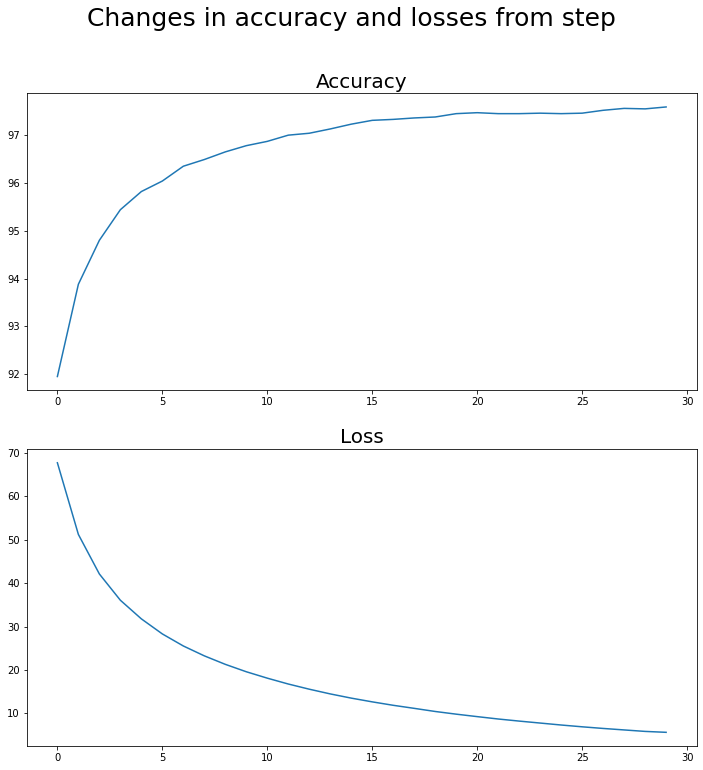

In [ ]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

# Место для вашего кода
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

axs[0].plot(range(len(accuracy_history)), accuracy_history, label='Accuracy')
axs[1].plot(range(len(accuracy_history)), loss_history, label='Loss')

axs[0].set_title('Accuracy', fontsize=20)
axs[1].set_title('Loss', fontsize=20)

fig.suptitle('Changes in accuracy and losses from step', fontsize=25)

plt.show()

In [ ]:
# Вычислите точность обученной нейросети
# Место для вашего кода
accuracy_history[-1]

97.58999943733215

In [ ]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронную сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?
# Место для вашего кода
y_for_5 = model(x_test[:5])
y2_for_5 = tf.argmax(y_for_5, axis=1).numpy()
print(y_test[:5] == y2_for_5)

[ True  True  True  True  True]


В данном случае модель не сделала ошибок в первых 5 изображениях

In [ ]:
def plot_images(images, true_value, predicted_value, value_cond = True, title='Correct examples'):
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    i = 0 
    for j, ax in enumerate(axes.flat):
        while True:
            if (true_value[i] == predicted_value[i]) == value_cond:
                break
            i+=1    
        ax.imshow(images[i].reshape(28, 28), cmap='binary')
        i+=1
    plt.suptitle(title, size=20)
    plt.show()

def plot_example_errors(images, true_value, predicted_value):
    np_array_errors = np.equal(predicted_value, true_value, dtype=object)
    error_images = []
    predicted_values = []
    correct_values = []
    for i in range(0, np_array_errors.shape[0]):
        if not np_array_errors[i]:
            error_images.append(images[i])
            predicted_values.append(predicted_value[i])
            correct_values.append(true_value[i])
    print(len(images) - len(error_images))
    plot_images(error_images, correct_values, predicted_values, value_cond = False, title='Incorrect examples')

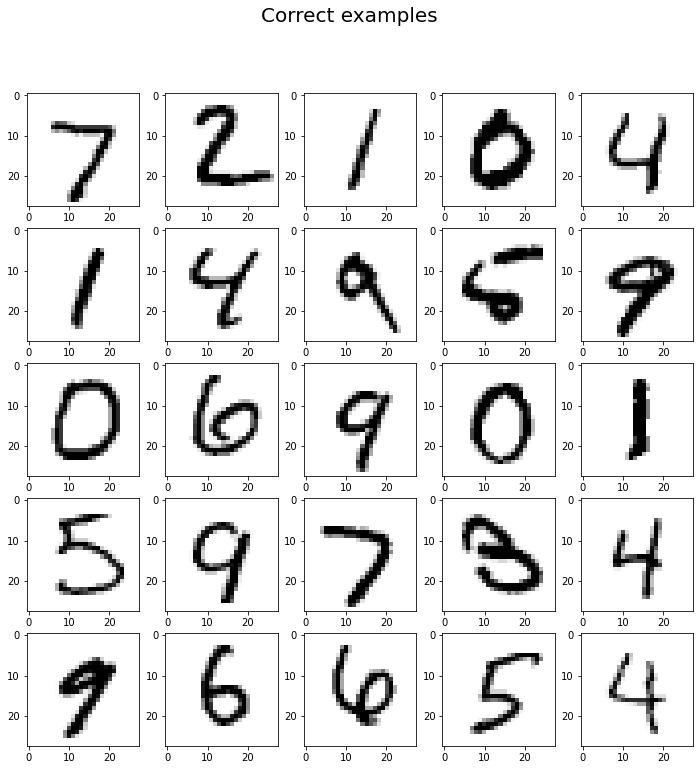

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: using `dtype=object` (or equivalent signature) will return object arrays in the future also when the inputs do not already have `object` dtype.
  from ipykernel import kernelapp as app


9759


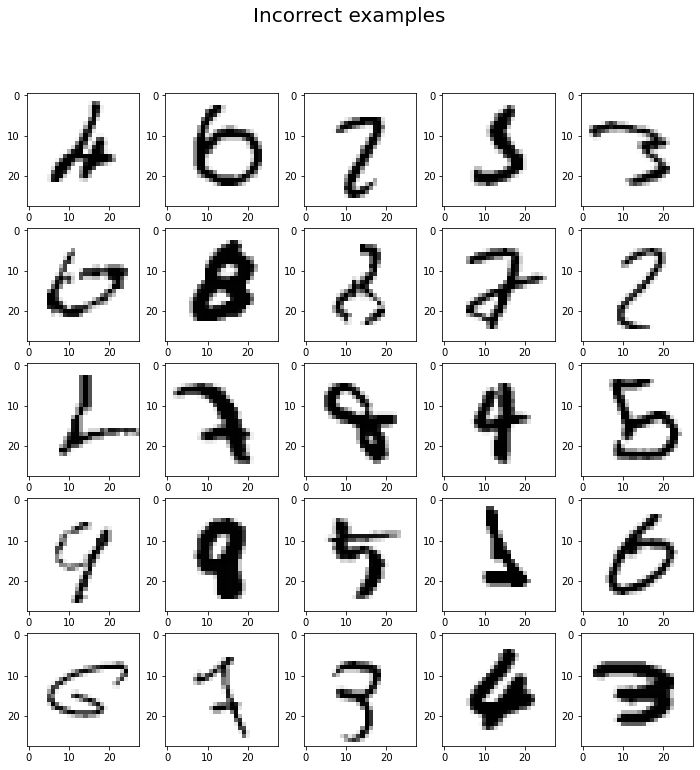

In [ ]:
np_config.enable_numpy_behavior()
true_value = y_test
predicted_value = y2
plot_images(x_test, true_value, predicted_value)
plot_example_errors(x_test, true_value, predicted_value)
plt.show()

Нейросеть ошибается но на таких данных где даже человеку не совсем понятно какая это цифра.
Из 10000 картинок определено было 9759.